In [3]:
# import matplotlib.pyplot as plt
# import imageio

# # Load the saved Shepp-Logan phantom image
# image =  imageio.imread('data/shepp_logan_phantom.png', mode='F')
# print(image.shape)
# # Display the loaded image
# plt.imshow(image, cmap='gray')
# plt.axis('off')  # Turn off axis labels
# plt.title('Shepp-Logan Phantom')
# plt.show()


/tmp/ipykernel_7852/2802656929.py:19: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image =  imageio.imread('data/shepp_logan_phantom.png', mode='L')


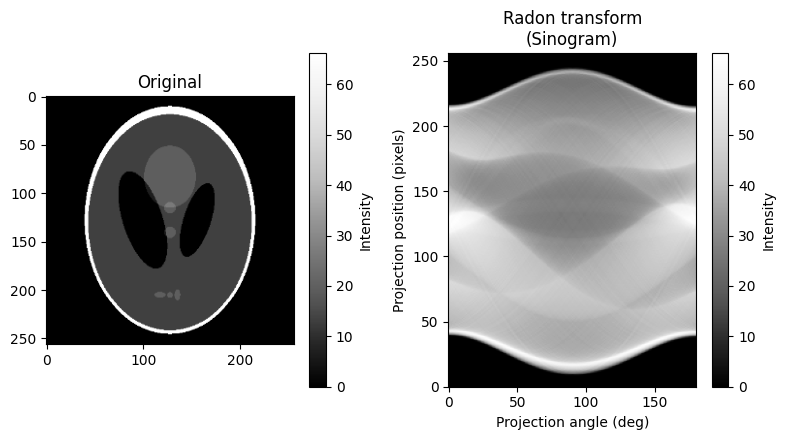

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.data import shepp_logan_phantom
from skimage.transform import radon, rescale
import imageio
# Function to generate a disk object
def generate_disk(size, radius, center):
    x, y = np.meshgrid(np.arange(size[1]), np.arange(size[0]))
    return ((x - center[0])**2 + (y - center[1])**2) < radius**2

# Generate a disk object
size = (120, 120)  # Adjust the size as needed
radius = 20
center = (100, 60)



# image = shepp_logan_phantom()
image =  imageio.imread('data/shepp_logan_phantom.png', mode='L')
image = rescale(image, scale=0.64, mode='reflect', channel_axis=None)
# image = generate_disk(size, radius, center)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5))

ax1.set_title("Original")
ax1.imshow(image, cmap=plt.cm.Greys_r)

theta = np.arange(0,180)
sinogram = radon(image, theta=theta)
dx, dy = 0.5 * 180.0 / max(image.shape), 0.5 / sinogram.shape[0]
ax2.set_title("Radon transform\n(Sinogram)")
ax2.set_xlabel("Projection angle (deg)")
ax2.set_ylabel("Projection position (pixels)")
cax = ax2.imshow(sinogram, cmap=plt.cm.Greys_r,
                 extent=(-dx, 180.0 + dx, -dy, sinogram.shape[0] + dy),
                 aspect='auto')

# Add color bar
cbar1 = plt.colorbar(cax, ax=ax1)
cbar1.set_label('Intensity')
cbar = plt.colorbar(cax, ax=ax2)
cbar.set_label('Intensity')

fig.tight_layout()
plt.show()

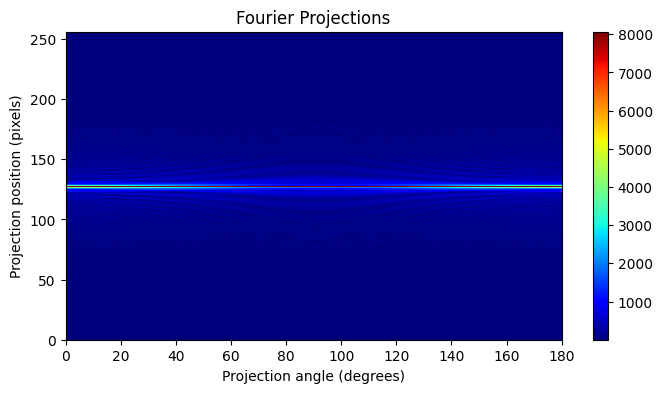

In [5]:
import numpy as np

# Assuming sinogram is your input data

# Shift zero-frequency component to the center along the first dimension
shifted_sinogram = np.fft.ifftshift(sinogram, axes=0)

# Compute the FFT along the first dimension
proj_fft = np.fft.fft(shifted_sinogram, axis=0)

# Get the length of the FFT
N = proj_fft.shape[0]

# # Create the filter
# filt = np.concatenate([2 * np.arange(N // 2 + 1) / N, 2 * np.arange(N // 2 - 1, 0, -1) / N])

# # Ensure the filter has the correct length
# filt = filt[:N]

# # Shift the zero-frequency component of the filter to the center
# H = np.fft.ifftshift(filt)

# # Apply the filter in the frequency domain
# proj_fft = proj_fft * np.tile(H[:, np.newaxis], (1, proj_fft.shape[1]))

# Shift the zero-frequency component back to the corner
proj_fft = np.fft.fftshift(proj_fft, axes=0)
# Display the Fourier projections
plt.figure(figsize=(8, 4))
plt.title("Fourier Projections")
plt.xlabel("Projection angle (degrees)")
plt.ylabel("Projection position (pixels)")
plt.imshow(np.abs(proj_fft), cmap='jet', aspect='auto', extent=(0, 180, 0, proj_fft.shape[0]))
plt.colorbar()
plt.show()

In [6]:
if N % 2 == 1:
    omega_r = np.arange(-N/2, (N+1)/2) * (2 * np.pi / N)  # define x axis of the FFT,
else:
    omega_r = np.arange(-(N-1)/2, (N+1)/2) * (2 * np.pi / N)

In [7]:
omega_theta = theta * np.pi / 180 # angles of the radial grid of FFT in rad

omega_xy = omega_r # we keep the same resolution in Fx and Fy axes

theta_grid, r_grid = np.meshgrid(omega_theta, omega_r) #create a radial grid for the FFT values that we have


In [8]:
omega_grid_x, omega_grid_y = np.meshgrid(omega_xy, omega_xy) # create the cartesian grid for the 2D FFT values

coord_th_fft2, coord_r_fft2 = np.angle(omega_grid_x + 1j * omega_grid_y), np.abs(omega_grid_x + 1j * omega_grid_y) #transform cartesian to polar coordinates

coord_r_fft2 *= np.sign(coord_th_fft2) #if theta>pi

coord_th_fft2 = coord_th_fft2 + np.pi / 2
coord_th_fft2[coord_th_fft2 < 0] += np.pi

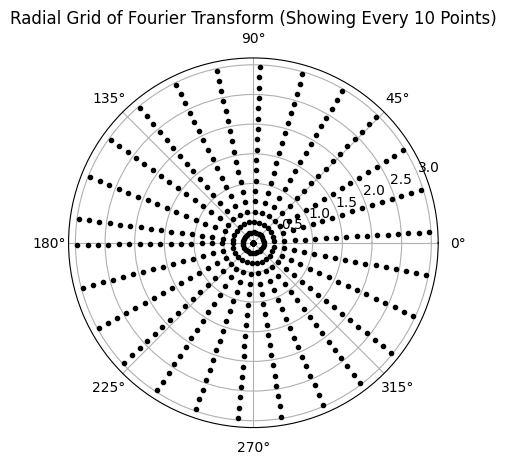

In [9]:
# Assuming omega_grid_x and omega_grid_y are already defined
display_interval=10

# Visualization of Radial Grid with every skip points
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

ax.plot(r_grid[::display_interval, ::display_interval], theta_grid[::display_interval, ::display_interval], 'k.')
ax.set_title(f'Radial Grid of Fourier Transform (Showing Every {display_interval} Points)')
ax.grid(True)
plt.show()

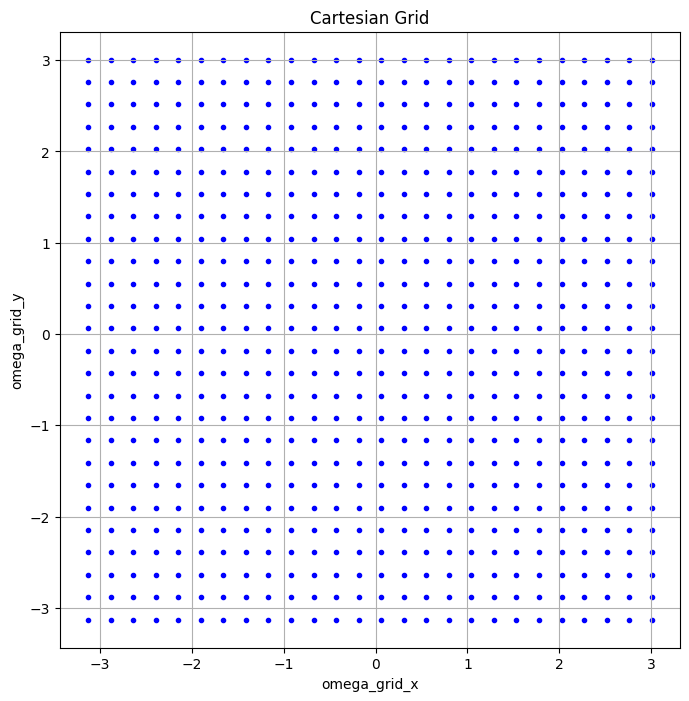

In [10]:
import matplotlib.pyplot as plt


# Plot the Cartesian grid
plt.figure(figsize=(8, 8))
plt.scatter(omega_grid_x[::display_interval, ::display_interval], omega_grid_y[::display_interval, ::display_interval], marker='.', color='b')
plt.title('Cartesian Grid')
plt.xlabel('omega_grid_x')
plt.ylabel('omega_grid_y')
plt.grid(True)
plt.show()


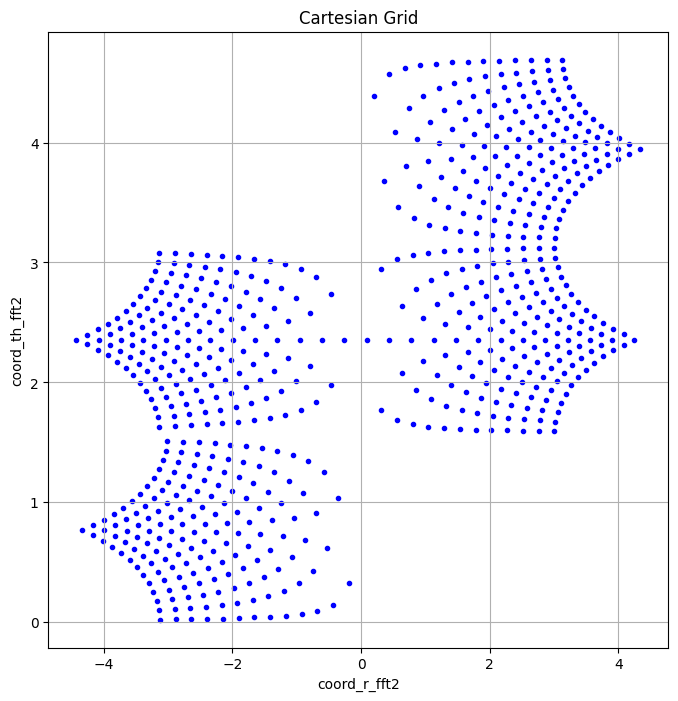

In [11]:
import matplotlib.pyplot as plt


# Plot the Cartesian grid
plt.figure(figsize=(8, 8))
plt.scatter(coord_r_fft2[::display_interval, ::display_interval], coord_th_fft2[::display_interval, ::display_interval], marker='.', color='b')
plt.title('Cartesian Grid')
plt.xlabel('coord_r_fft2')
plt.ylabel('coord_th_fft2')
plt.grid(True)
plt.show()


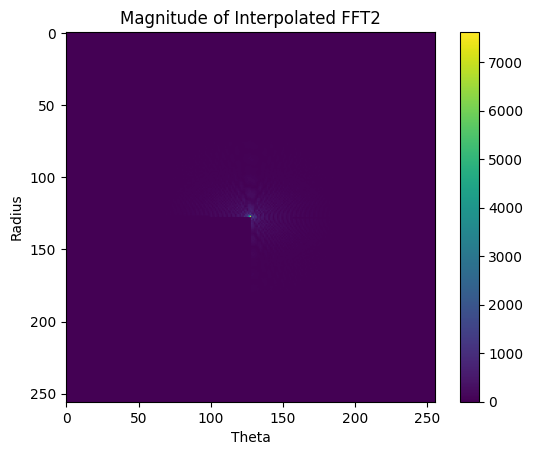

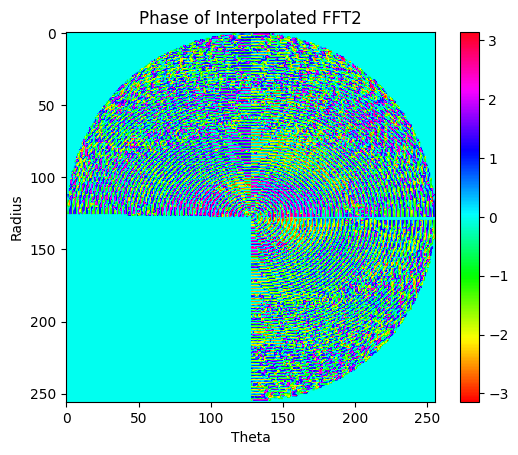

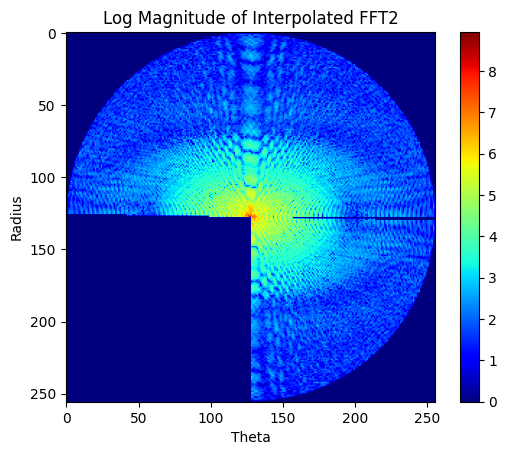

In [12]:
from scipy.interpolate import griddata
# MATLAB: FFT2 = interp2(theta_grid,r_grid,proj_fft,coord_th_fft2,coord_r_fft2,'bilinear',(0+1i.*0)); %   
points = np.column_stack((r_grid.flatten(), theta_grid.flatten()))
values = proj_fft.flatten()
# Define points where interpolation is needed
points_q = np.column_stack((coord_r_fft2.flatten(), coord_th_fft2.flatten()))
# Perform bilinear interpolation
FFT2 = griddata(points, values, points_q, method='cubic', fill_value=0+1j*0) #interpolate coefficients that we have to the grid points Fx, Fy

# Reshape the result to match the shape of coord_th_fft2 and coord_r_fft2
FFT2 = FFT2.reshape(coord_r_fft2.shape, )
# FFT2_flipped = np.flipud(FFT2))
FFT2_flipped = np.flipud(np.rot90(FFT2, k=3))
plt.imshow(np.abs(FFT2_flipped))
plt.colorbar()
plt.title('Magnitude of Interpolated FFT2')
plt.xlabel('Theta')
plt.ylabel('Radius')
plt.show()

# Plot phase of interpolated FFT2
plt.imshow(np.angle(FFT2_flipped), cmap='hsv')
plt.colorbar()
plt.title('Phase of Interpolated FFT2')
plt.xlabel('Theta')
plt.ylabel('Radius')
plt.show()

# Plot log magnitude of interpolated FFT2
plt.imshow(np.log(np.abs(FFT2_flipped) + 1), cmap='jet')
plt.colorbar()
plt.title('Log Magnitude of Interpolated FFT2')
plt.xlabel('Theta')
plt.ylabel('Radius')
plt.show()


In [13]:
from numpy.fft import fftshift, ifft2, ifftshift

# Assuming FFT2 is already defined

# Perform the inverse operations
I = ifftshift(ifft2(fftshift(FFT2_flipped)))

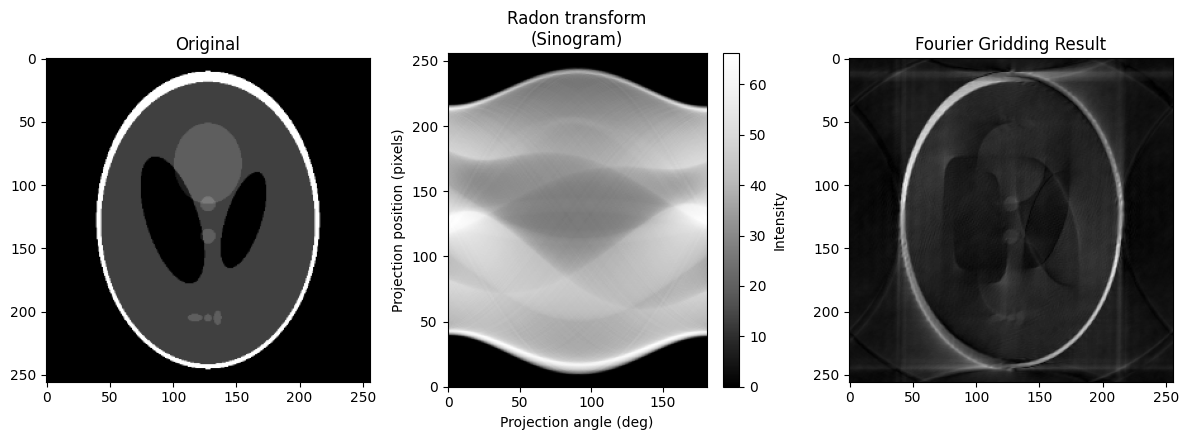

In [14]:
# Original Image
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4.5))

ax1.set_title("Original")
ax1.imshow(image, cmap=plt.cm.Greys_r)

# Radon Transform (Sinogram)
theta = np.arange(0, 180, 1)
sinogram = radon(image, theta=theta)
dx, dy = 0.5 * 180.0 / max(image.shape), 0.5 / sinogram.shape[0]
ax2.set_title("Radon transform\n(Sinogram)")
ax2.set_xlabel("Projection angle (deg)")
ax2.set_ylabel("Projection position (pixels)")
cax = ax2.imshow(sinogram, cmap=plt.cm.Greys_r,
                 extent=(-dx, 180.0 + dx, -dy, sinogram.shape[0] + dy),
                 aspect='auto')

# Add color bar
cbar2 = plt.colorbar(cax, ax=ax2)
cbar2.set_label('Intensity')

# Fourier Gridding  Result
ax3.set_title('Fourier Gridding Result')
ax3.imshow(np.abs(I), cmap='gray')

fig.tight_layout()
plt.show()

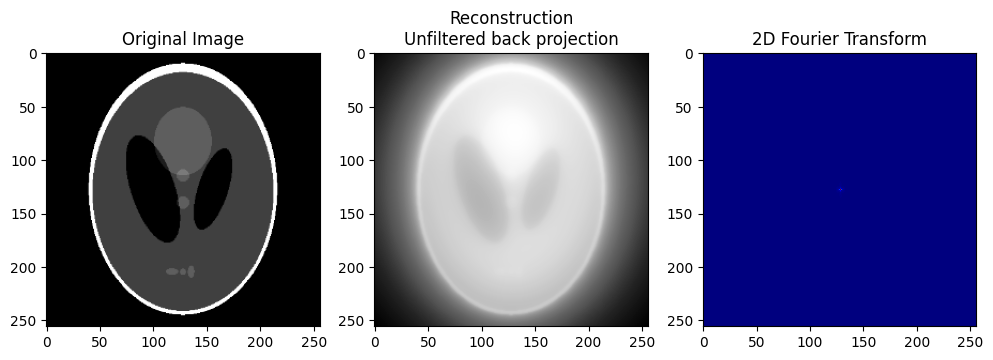

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import iradon
from scipy.fft import fft2, fftshift

# Assuming 'sinogram' is your input sinogram and 'theta' is the array of projection angles
# Make sure 'theta' is in degrees

# Perform filtered backprojection reconstruction
reconstruction_fbp = iradon(sinogram, theta=theta, filter_name=None, circle=False, output_size=image.shape[0])

# Perform 2D Fourier Transform
reconstruction_ft = fftshift(fft2(reconstruction_fbp))

# Display the original image, reconstruction, and Fourier Transform
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
ax1.set_title("Original Image")
ax1.imshow(image, cmap=plt.cm.Greys_r)

ax2.set_title("Reconstruction\nUnfiltered back projection")
ax2.imshow(reconstruction_fbp, cmap=plt.cm.Greys_r)

ax3.set_title("2D Fourier Transform")
ax3.imshow(np.abs(reconstruction_ft), cmap=plt.cm.jet)

plt.show()


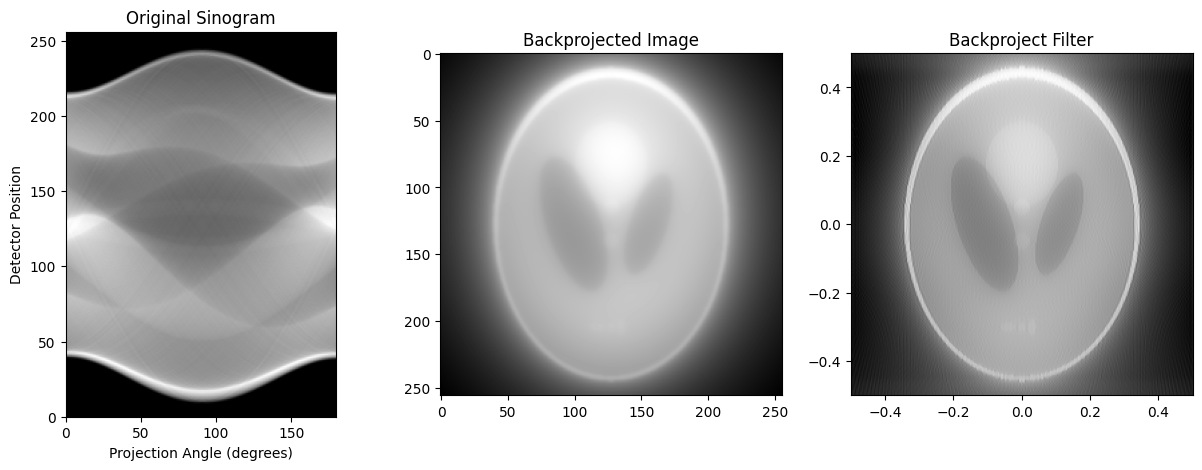

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import iradon
from scipy.fft import fft2, fftshift
def cone_filter(frequency_spectrum, u, v, window_size=15, angular_weighting=None):
    # Compute angle in radians
    angle = np.angle(np.pi * (u + 1j * v))

    # Apodizing lowpass filter
    std_deviation = 0.25  # Adjust this value as needed
    A = np.exp(-(u**2 + v**2) / (2 * (std_deviation**2)))
    a = 10  # Adjust this value as needed
    A = np.exp(-a * np.sqrt(u**2 + v**2))
    # Windowing function
    w = np.sinc(angle / np.pi)

    # Angular weighting function
    if angular_weighting is not None:
        w *= angular_weighting(angle)

    # Frequency domain modification
    modified_spectrum = A * np.sqrt(u**2 + v**2) * w * frequency_spectrum

    # Inverse Fourier transform to get the reconstructed image
    reconstructed_image = np.real(np.fft.ifft2(modified_spectrum))

    return reconstructed_image
# Define the frequency coordinates
u = np.fft.fftfreq(reconstruction_ft.shape[1])
v = np.fft.fftfreq(reconstruction_ft.shape[0])

# Apply cone filter to the 2D Fourier transform
filtered_image = cone_filter(reconstruction_ft, u, v)

# Display the original sinogram, the reconstructed image, and the filtered image
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(sinogram, cmap='gray', extent=[0, 180, 0, sinogram.shape[0]])
plt.title('Original Sinogram')
plt.xlabel('Projection Angle (degrees)')
plt.ylabel('Detector Position')

plt.subplot(1, 3, 2)
plt.imshow(reconstruction_fbp, cmap='gray')
plt.title('Backprojected Image')

plt.subplot(1, 3, 3)
plt.imshow(np.abs(filtered_image), cmap='gray', extent=[-0.5, 0.5, -0.5, 0.5])  # Displaying the central region of the spectrum
plt.title('Backproject Filter')

plt.show()


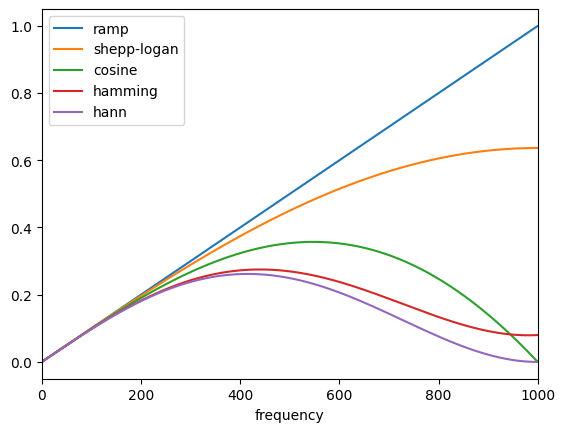

In [17]:
import matplotlib.pyplot as plt
from skimage.transform.radon_transform import _get_fourier_filter

filters = ['ramp', 'shepp-logan', 'cosine', 'hamming', 'hann']

for ix, f in enumerate(filters):
    response = _get_fourier_filter(2000, f)
    plt.plot(response, label=f)

plt.xlim([0, 1000])
plt.xlabel('frequency')
plt.legend()
plt.show()

FBP rms reconstruction error: 0.0289


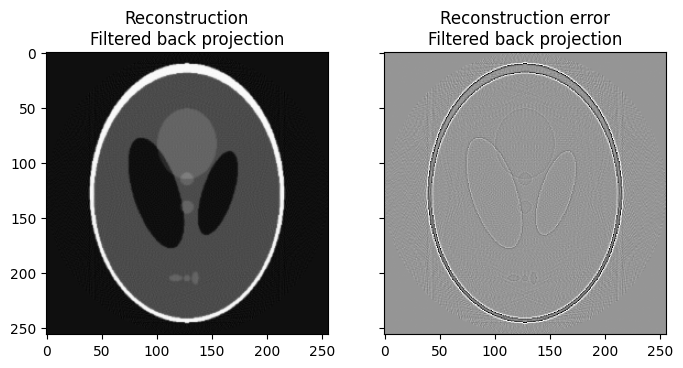

In [18]:
reconstruction_fbp = iradon(sinogram, theta=theta, filter_name='ramp')
error = reconstruction_fbp - image
print(f'FBP rms reconstruction error: {np.sqrt(np.mean(error**2)):.3g}')

imkwargs = dict(vmin=-0.2, vmax=0.2)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5),
                               sharex=True, sharey=True)
ax1.set_title("Reconstruction\nFiltered back projection")
ax1.imshow(reconstruction_fbp, cmap=plt.cm.Greys_r)
ax2.set_title("Reconstruction error\nFiltered back projection")
ax2.imshow(reconstruction_fbp - image, cmap=plt.cm.Greys_r, **imkwargs)
plt.show()